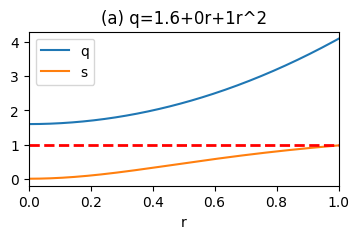

In [12]:
# Reduced resistive MHD eigenvalue solver (RMES) in cylindrical geometry (in the limit of zero plasma beta)
# Tool - 
# 1. Linear stable and unstable tearing mode and spectrum analysis (with complex eigenvalues) 
# 2. unstable tearing modes ( with almost real eigenvalue near to marginal stability threshold)
# 3. Resistive growth rates of unstable modes
#Ref. 
# 1. A.Bierwage et al. Phys. Plasmas 14, 022107 (2007); https://doi.org/10.1063/1.2446420]
# 2. A. Bierwage, S. Benkadda, S. Hamaguchi, and M. Wakatani, Phys. Plasmas 12, 082504 2005


import sys
write = sys.stdout.write
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from scipy.sparse import diags, eye
from scipy.sparse.linalg import eigs
from scipy.sparse import lil_matrix 

Nt = 2**8
r = np.linspace(0, 1, Nt+2)
dr = r[1] - r[0]

# Equilibrium profiles
q0=1.6
q1=0 
q2=1
#for CGJ model
q= q0*(1+(r/0.8)**2) 
dq=2*q0*r/0.8  
ddq=5*q0/2
s = r * dq / q
sp = (r * q * ddq + q * dq - dq**2 * r) / q**2
eta = 7e-9 + 0 * r # radial resistivity
nu = 0.0 # radial viscosity

#Poloidal(m) and toroidal(n) mode numbers; note m,n >=1 , m=n=0 not applicable 
m = 2 
n = 1

#Plotting profiles safety factor 'q', shear 's', resistivity '\eta', and viscosity '\nu' as a function of radial co-ordinate 'r' 
h = plt.figure(figsize=(4, 2))
plt.plot(r, q, label='q')
plt.plot(r, s, label='s')
plt.plot([0, 1], [1, 1], 'r--', linewidth=2)
plt.xlabel('r')
plt.xlim([0, 1])
plt.legend()
plt.title(f'(a) q={q0}+{q1}r+{q2}r^2')


#Discretization based on second-order central and first order forward difference schemes
ri = r[1:Nt+1]  
qi = q[1:Nt+1]
si = s[1:Nt+1]
spi = sp[1:Nt+1]
etai = eta[1:Nt+1]

#Define matrix elements for A and B - mostly tri-diagonal and sparse matrix 

rhoi_p = (1.0 / dr**2 + 1.0/ (2.0 * ri * dr))  # rho_j(+1)
rhoi_0 = 1.0*ri - 2.0 / dr**2  # rho_i(0)
rhoi_m = (1.0 / dr**2 - 1.0 / (2.0 * ri * dr))  # rho_j(-1)

DI = diags([rhoi_0, rhoi_m[1:], rhoi_p[:Nt-1]], [0, -1, 1], shape=(Nt, Nt),  dtype= complex)

I = eye(Nt, Nt)
O = diags([0], [0], shape=(Nt, Nt))

tmp1 = m**2 / ri**2
Diag1 = diags([tmp1], [0], shape=(Nt, Nt), dtype = complex)

tmp2 = -m**2 * etai / ri**2
Diag2 = diags([tmp2], [0], shape=(Nt, Nt), dtype = complex)

tmp3 = 1j * (n - m / qi)
Diag3 = diags([tmp3], [0], shape=(Nt, Nt), dtype = complex)

tmp4 = -1j * ((n - m / qi) * m**2 / ri**2 + m / ri * (spi / qi - si * (si - 2) / (ri * qi)))
Diag4 = diags([tmp4], [0], shape=(Nt, Nt), dtype = complex)

tmp5 = m**4 * nu / ri**4
Diag5 = diags([tmp5], [0], shape=(Nt, Nt), dtype = complex)

tmp6 = etai
Diag6 = diags([tmp6], [0], shape=(Nt, Nt), dtype = complex)

S = DI.toarray() - Diag1.toarray()

In [10]:
# set matrices A and B
B= lil_matrix((2*Nt,2*Nt), dtype= complex)
C= lil_matrix((2*Nt,2*Nt), dtype= complex)
D= lil_matrix((2*Nt,2*Nt), dtype= complex)

#Here matrices A and B are not a postive-definite (non-hermitian).  
B[:Nt,:Nt] = I #1
B[Nt:,Nt:] = S #4
B[Nt:,:Nt] = O #3
B[:Nt,Nt:] = O #2 

C[:Nt,:Nt] = Diag2 #.diagonal() #1
C[Nt:,Nt:] = Diag5 #.diagonal() #4
C[Nt:,:Nt] = Diag4 #.diagonal() #3
C[:Nt,Nt:] = Diag3 #.diagonal() #2 

D[:Nt,:Nt] = Diag6 * DI #1
D[Nt:,Nt:] = nu * (DI @ DI - Diag1 @ DI - DI @ Diag1) #4
D[Nt:,:Nt] = Diag3*DI      #3
D[:Nt,Nt:] = O  #2
 

A = C.toarray() + D.toarray()
B = B.toarray()

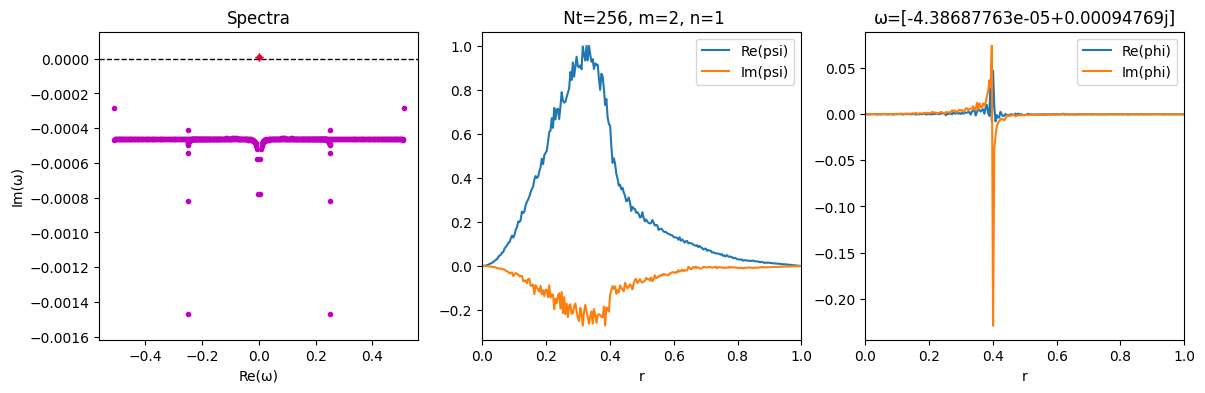

In [11]:

# Solve the generalrized eigenvalue problem: A * vecs = eigvals * B * vecs
eigvals, vecs = eigs(A,4,B, sigma=0.001)
r = np.where(np.real(eigvals) == np.max(np.max(np.real(eigvals))))
w = 1.0j*eigvals[r]
psi = vecs[:Nt,r[0]]
phi = vecs[Nt:,r[0]]
norm = np.real(psi[np.argmax(np.abs(psi))])
psi = psi/np.max(norm)   # Magnetic flux function for current denisty
phi = phi/np.max(norm)   # Electrostatic potentail for vorticity

#Ploting all eigenvalues (spectrum analysis) 
if Nt <= 2**8:  
    e,v = scipy.linalg.eig(A,B)
    idx = np.argsort(e)
    e = e[idx]
    de = 1j * e
    h = plt.figure(figsize=(14, 4))
    plt.subplot(1, 3,1)
    ind = np.where(np.imag(de) > 0)
    xmax = 1.1 * np.max(np.abs(np.real(de)))
    ymax = np.max(np.imag(de))
    ymin = np.min(np.imag(de))
    plt.plot(np.real(de), np.imag(de), 'm.', linewidth=1.0)
    plt.plot(np.real(de[ind]), np.imag(de[ind]), 'r+', linewidth=1.0)
    plt.plot([-xmax, xmax], [0, 0], 'k--', linewidth=1.)
    plt.axis([-xmax, xmax, 1.1*ymin-0.1*ymax, 1.1*ymax-0.1*ymin])
    plt.xlabel('Re(\u03C9)')
    plt.ylabel('Im(\u03C9)')
    plt.title('Spectra')

plt.subplot(1, 3, 2)
plt.plot(ri, np.real(psi),'-', label='Re(psi)')
plt.plot(ri, np.imag(psi),'-', label='Im(psi)')
plt.xlabel('r')
plt.xlim([0,1])
plt.legend()
plt.title(f' Nt={Nt}, m={m}, n={n}')

plt.subplot(1, 3, 3)
plt.plot(ri, np.real(phi),'-',label='Re(phi)')
plt.plot(ri,np.imag(phi),'-',label='Im(phi)')
plt.xlabel('r')
plt.xlim([0,1])
plt.legend()
plt.title(f'\u03C9={str(w)}')
plt.show()